## Motivation
I enjoy making drawings where I decide a set of rules and see them through to completetion. This is the result of such a project.

One day I was doodling and inscribed a hexagon in a circle. I thought, what if I drew pentagons next to each edge of the hexagon, such that the edges of the pentagons and hexagon where parallel? Naturally, I thought, the pentagons should be sized such that if they were in inscribed in circles, those circles would be the same size as the one that hexagon was inscribed in. Then, I could draw the pentagons inscribed in circles in a way that the hexagon circle and pentagon circle would be tangent to each other (that is, barely touching). Of course, after drawing the pentagons, I could draw squares in relation to the pentagons, then triangles in relation to the squares... Starting to see this through made me discover some interesting properties of inscribing shapes in circles with a compass and straight edge.

This made me think of some cool geometry problems. The center of the next generation of circles would be drawn $2r$ away from the center of the origin circle, if $r$ is the radius of the circle.

Of course, this drawing became tedious after awhile and I never did finish it. Instead, I wondered if I could write a program to do it. I had a rule set and a number of starting parameters, so I thought it would be straight forward enough. Given a number of sides, $n$, a radius, $r$, and an initial direction to draw the "seed" shape, a program could complete my drawing with a simple recursion. That's what I ended up making here.

### Initial attempt
The first iteration of this program was made using Turtle. Turtle is a fun and simple drawing utility that comes packaged with python with the intention of being used to teach programming. With turtle, you move and turn a pen, leaving a trail when you see fit. Using Turtle, I closely mimicked the actual drawing process by calculating where the center of a new circle should go, where the first vertex of a shape should go, and then turning the turtle by a set angle and moving it forward by a set distance. This gave rise to a fun geometry problem:

#### Given a circle of radius r inscribed with a polygon with number of sides n, what is the length of n?

Let $\theta$ be the interior angle of a polygon with number of sides $n$. <br>
then, $\theta = \frac{180(n-2)}{n}$ <br>
For a polygon inscribed in a circle of radius $r$, the length of a side of the polygon is given as $2rcos\theta$<br>
So, the length of a side $n$ is given as <br>
$2rcos(\frac{1}{2} \times \frac{180(n-2)}{n})$

### Later attempt
The turtle program worked and was pretty neat, but turtle drawings don't anti-alias so the end results were kind of ugly (though it was fun to watch the drawings be animated into existence). I wanted to make something prettier, so I landed with PyCairo.

For the PyCairo implementation, I couldn't simply tell the program to move the pen a distance for a certain heading. Instead, I had to calculate the position on euclidean co-ordinates that the vertices of shapes would be drawn, then conenct lines between them. Ultimately, this ended up being not much harder to figure out (maybe even a bit easier) and was also pretty fun. The Cairo version is what is found in this notebook, and the end results look really good, in my opinion. Anyway, try running these and have fun!

In [1]:
#Imports
import cairo
from IPython.display import Image, display, SVG
import seaborn as sns
from math import pi
import math
from io import BytesIO
import numpy as np

In [2]:
# This is for making random colors. I don't end up using it, I ended up using a seaborn palette instead.
import random
r = lambda: random.randint(0,255) / 255
rc = lambda: [r(), r(), r(), 0.7]

In [3]:
# I want to be able accept a center, heading, nsides, circle radius.

# Draws the circle and shape.
def draw_inscribed_circle(cr, center, heading, radius, nsides, circle):
    cx, cy = center
    c = cmap[nsides-3]
    cr.set_source_rgba(*c)
    cr.move_to(*center)
    cr.stroke()
    if circle:
        cr.arc(*center, radius, 0, 2*pi)
        cr.stroke()
    incr = math.radians(360/nsides)
    if nsides % 2 == 0:
        heading = heading - math.radians(360/nsides/2)
    
    last_x = cx + np.cos(heading) * radius
    last_y = cy + np.sin(heading) * radius
    for i in range(nsides+1):
        this_x = cx + np.cos(heading+incr*i) * radius
        this_y = cy + np.sin(heading + incr*i) * radius
        cr.move_to(last_x, last_y)
        cr.line_to(this_x, this_y)
        cr.stroke()
        last_x, last_y = this_x, this_y

# Return sets of (center, heading). Indicates where the next circles should be drawn
def get_next_sets(cr, center, heading, radius, nsides):
    sets = []
    init_hd = heading# - math.radians(360/nsides/2)
    incr = math.radians(360/nsides)
    for i in range(nsides):
        cr.move_to(*center)
        x = center[0] + np.cos(init_hd + i * incr) * 2*radius
        y = center[1] + np.sin(init_hd + i * incr)*2*radius
        sets.append([(x,y), init_hd + i * incr])
    
    return sets    
    
def recursive_shapes(cr, origin, heading, radius, nsides, circle=True):
    draw_inscribed_circle(cr, center=origin, heading=heading, radius=radius, nsides=nsides, circle=circle)
    if nsides >= 4:
        next_sides = nsides-1
        sets = get_next_sets(cr, center=origin, heading=heading, radius=radius, nsides=nsides)
        for s in sets:
            recursive_shapes(cr, origin=s[0], heading=s[1], radius=radius, nsides=next_sides, circle=circle)
            



#### Using nsides=4 illustrates the idea that drives this program.
Given a shape with n sides, draw shapes with n - 1 sides such that:
1. The circles that the shapes would be inscribed in all have the same radius
2. If you draw a line from the center of the new shape's circle to the center of the old shape's circle, the line will perfectly bisect an edge of the original shape
3. every edge of the original shape will have such a bisecting line
4. The new shapes will be drawn far enough away s.t. the circles inscribing the old shape and the new shapes are tangent

The shapes will scale to fit the canvas exactly.<br>
You can choose to inscribe the shapes in circles or not. <br>
The shapes are drawn recursively. <br> 

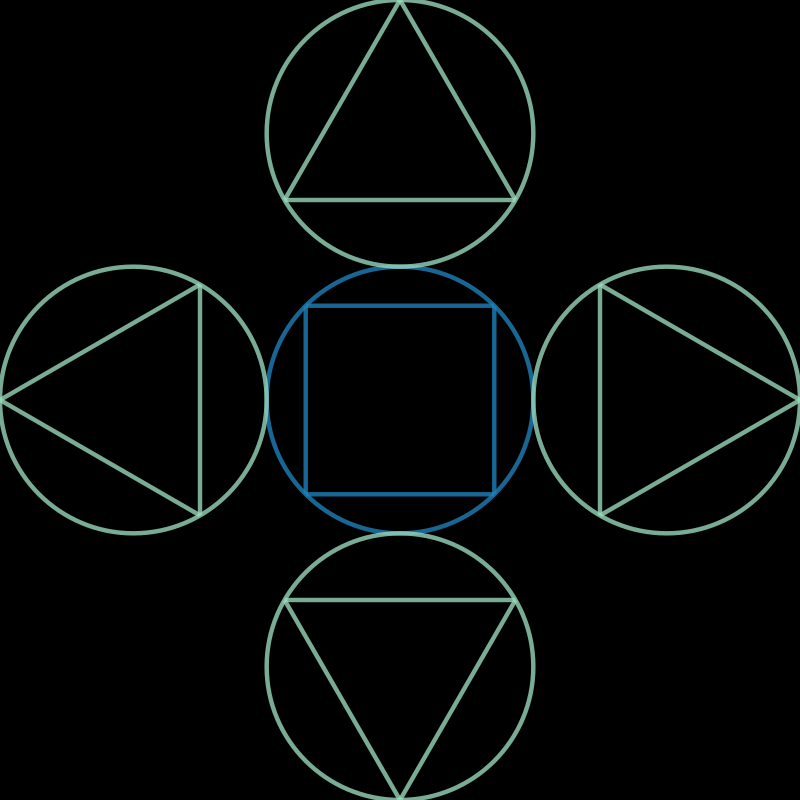

In [46]:
#Simplest example: nsides of the initial shape is 4. 
# So a square will be drawn, with a trangle on each edge of the square

### CHANGE THESE TO MESS WITH THE ART ###

WIDTH = 800
HEIGHT = 800
nsides = 4 # number gte 3. Recommend 7 or less
alpha = 0.8 #alpha channel of the lines. Lower values work better with higher nsides. must be between 0 and 1.
heading = -pi/2 #The direction in radians that the Apex of the center shape will point
palette = 'YlGnBu' # a seaborn color palette
draw_circles = True # whether to inscribe shapes in circles
###


cmap = {i:[*c, alpha] for i, c, in enumerate(sns.color_palette(palette, nsides-2))}
radius = 1 / (((nsides-3)*2 + 1) * 2)
surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, WIDTH, HEIGHT)
ctx = cairo.Context(surface)
ctx.scale(WIDTH, HEIGHT)

ctx.rectangle(0, 0, WIDTH, HEIGHT)
ctx.set_source_rgb(0,0,0)
ctx.fill()

ctx.set_line_width(radius/30)
recursive_shapes(ctx, origin=(0.5,0.5), heading=heading, radius=radius, nsides=nsides, circle=draw_circles)

io = BytesIO()
surface.write_to_png(io)
display(Image(io.getvalue()))

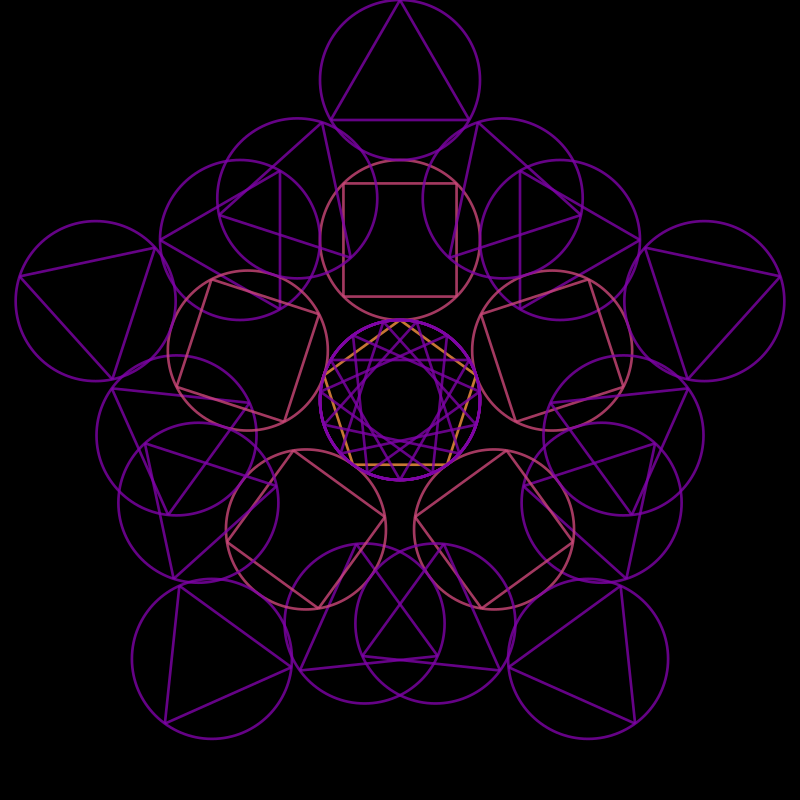

In [47]:
### CHANGE THESE TO MESS WITH THE ART ###

WIDTH = 800
HEIGHT = 800
nsides = 5 # number gte 3. Recommend 7 or less
alpha = 0.8 #alpha channel of the lines. Lower values work better with higher nsides. must be between 0 and 1.
heading = -pi/2 #The direction in radians that the vertex of the center shape will point
palette = 'plasma' # a seaborn color palette
draw_circles = True # whether to inscribe shapes in circles
###


cmap = {i:[*c, alpha] for i, c, in enumerate(sns.color_palette(palette, nsides-2))}
radius = 1 / (((nsides-3)*2 + 1) * 2)
surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, WIDTH, HEIGHT)
ctx = cairo.Context(surface)
ctx.scale(WIDTH, HEIGHT)

ctx.rectangle(0, 0, WIDTH, HEIGHT)
ctx.set_source_rgb(0,0,0)
ctx.fill()

ctx.set_line_width(radius/30)
recursive_shapes(ctx, origin=(0.5,0.5), heading=heading, radius=radius, nsides=nsides, circle=draw_circles)

io = BytesIO()
surface.write_to_png(io)
display(Image(io.getvalue()))

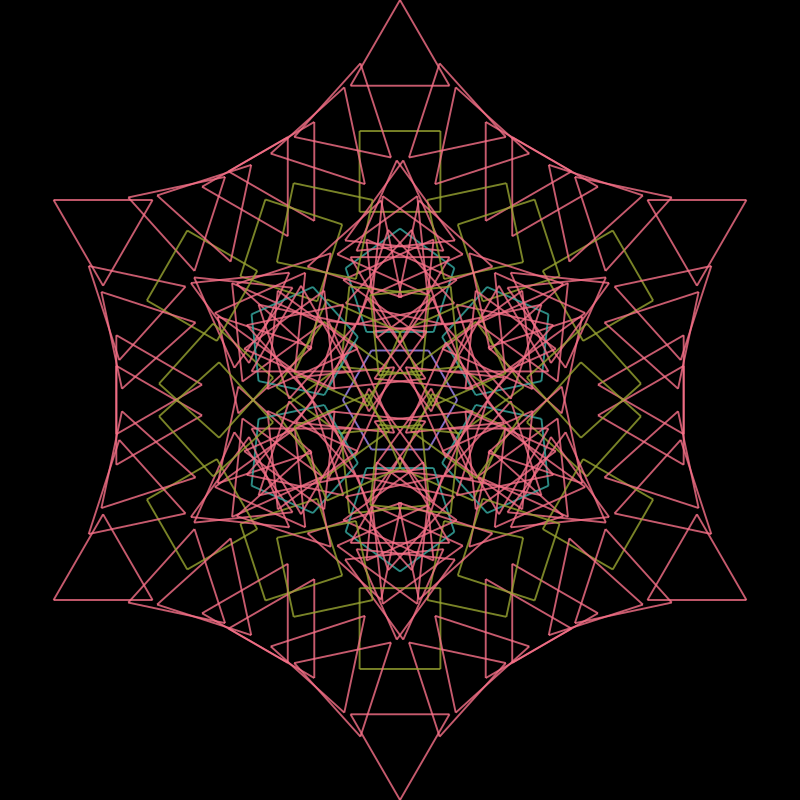

In [48]:
### CHANGE THESE TO MESS WITH THE ART ###

WIDTH = 800
HEIGHT = 800
nsides = 6 # number gte 3. Recommend 7 or less
alpha = 0.8 #alpha channel of the lines. Lower values work better with higher nsides. must be between 0 and 1.
heading = -pi/2 #The direction in radians that the vertex of the center shape will point
palette = 'husl' # a seaborn color palette
draw_circles = False # whether to inscribe shapes in circles
###


cmap = {i:[*c, alpha] for i, c, in enumerate(sns.color_palette(palette, nsides-2))}
radius = 1 / (((nsides-3)*2 + 1) * 2)
surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, WIDTH, HEIGHT)
ctx = cairo.Context(surface)
ctx.scale(WIDTH, HEIGHT)

ctx.rectangle(0, 0, WIDTH, HEIGHT)
ctx.set_source_rgb(0,0,0)
ctx.fill()

ctx.set_line_width(radius/30)
recursive_shapes(ctx, origin=(0.5,0.5), heading=heading, radius=radius, nsides=nsides, circle=draw_circles)

io = BytesIO()
surface.write_to_png(io)
display(Image(io.getvalue()))

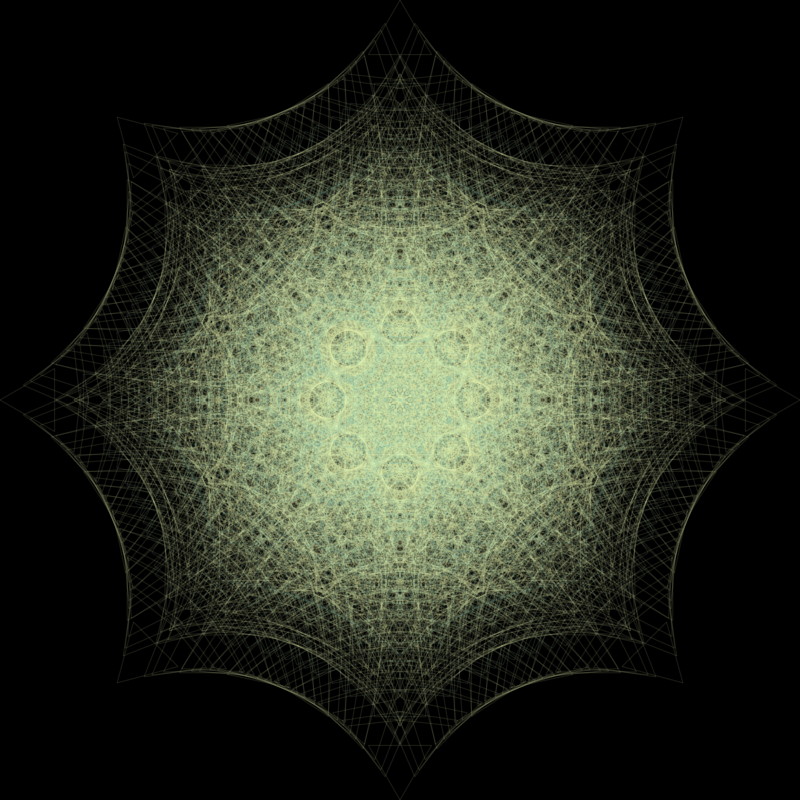

In [49]:
### CHANGE THESE TO MESS WITH THE ART ###

WIDTH = 800
HEIGHT = 800
nsides = 8 # number gte 3. Recommend 7 or less
alpha = 0.1 #alpha channel of the lines. Lower values work better with higher nsides. must be between 0 and 1.
heading = -pi/2 #The direction in radians that the vertex of the center shape will point
palette = 'YlGnBu' # a seaborn color palette
draw_circles = False # whether to inscribe shapes in circles
###


cmap = {i:[*c, alpha] for i, c, in enumerate(sns.color_palette(palette, nsides-2))}
radius = 1 / (((nsides-3)*2 + 1) * 2)
surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, WIDTH, HEIGHT)
ctx = cairo.Context(surface)
ctx.scale(WIDTH, HEIGHT)

ctx.rectangle(0, 0, WIDTH, HEIGHT)
ctx.set_source_rgb(0,0,0)
ctx.fill()

ctx.set_line_width(radius/30)
recursive_shapes(ctx, origin=(0.5,0.5), heading=heading, radius=radius, nsides=nsides, circle=draw_circles)

io = BytesIO()
surface.write_to_png(io)
display(Image(io.getvalue()))

In [11]:
### CHANGE THESE TO MESS WITH THE ART ###

WIDTH = 1600
HEIGHT = 1600
nsides = 8 # number gte 3. Recommend 7 or less
alpha = 0.1 #alpha channel of the lines. Lower values work better with higher nsides. must be between 0 and 1.
heading = -pi/2 #The direction in radians that the vertex of the center shape will point
palette = 'YlGnBu' # a seaborn color palette
draw_circles = False # whether to inscribe shapes in circles
###


cmap = {i:[*c, alpha] for i, c, in enumerate(sns.color_palette(palette, nsides-2))}
radius = 1 / (((nsides-3)*2 + 1) * 2)
surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, WIDTH, HEIGHT)
#surface.set_device_scale(1,1)
ctx = cairo.Context(surface)
ctx.scale(WIDTH, HEIGHT)

ctx.rectangle(0, 0, WIDTH, HEIGHT)
ctx.set_source_rgb(0,0,0)
ctx.fill()

ctx.set_line_width(radius/30)
recursive_shapes(ctx, origin=(0.5,0.5), heading=heading, radius=radius, nsides=nsides, circle=draw_circles)

io = BytesIO()
#surface.write_to_png(io)
#display(Image(io.getvalue()))
surface.write_to_png('/home/alex/Pictures/octagon.png')

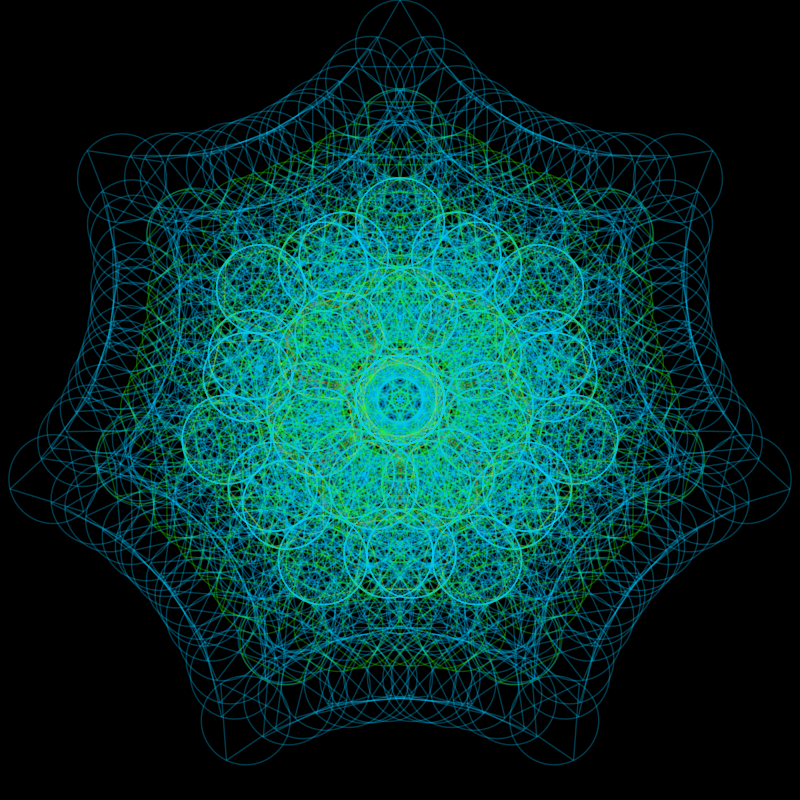

In [53]:
### CHANGE THESE TO MESS WITH THE ART ###

WIDTH = 800
HEIGHT = 800
nsides = 7 # number gte 3. Recommend 7 or less
alpha = 0.3 #alpha channel of the lines. Lower values work better with higher nsides. must be between 0 and 1.
heading = -pi/2 #The direction in radians that the vertex of the center shape will point
palette = 'gist_ncar' # a seaborn color palette
draw_circles = True # whether to inscribe shapes in circles
###


cmap = {i:[*c, alpha] for i, c, in enumerate(sns.color_palette(palette, nsides-2))}
radius = 1 / (((nsides-3)*2 + 1) * 2)
surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, WIDTH, HEIGHT)
ctx = cairo.Context(surface)
ctx.scale(WIDTH, HEIGHT)

ctx.rectangle(0, 0, WIDTH, HEIGHT)
ctx.set_source_rgb(0,0,0)
ctx.fill()

ctx.set_line_width(radius/30)
recursive_shapes(ctx, origin=(0.5,0.5), heading=heading, radius=radius, nsides=nsides, circle=draw_circles)

io = BytesIO()
surface.write_to_png(io)
display(Image(io.getvalue()))

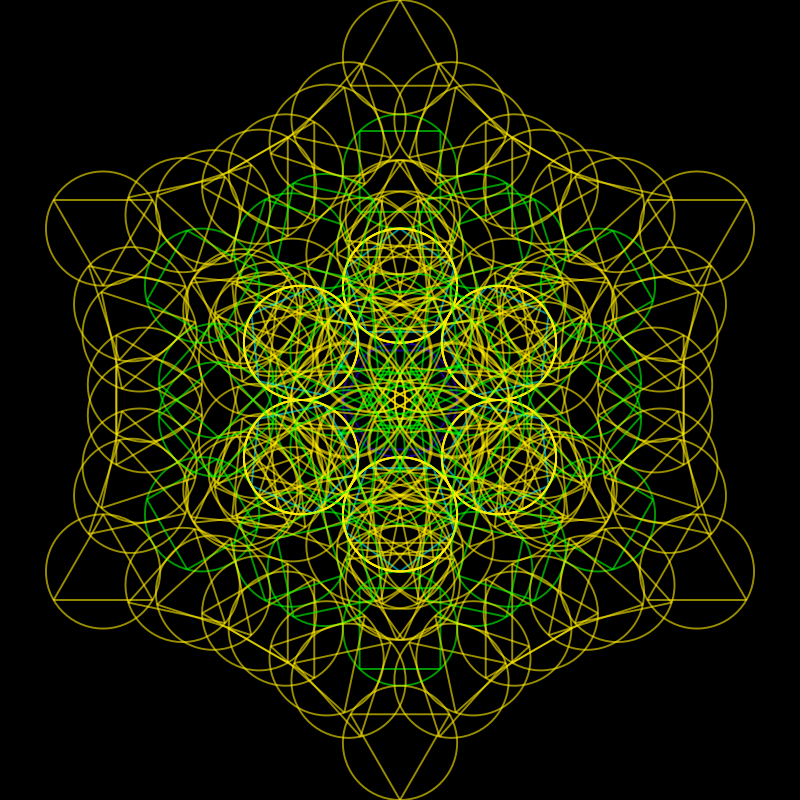

In [61]:
### CHANGE THESE TO MESS WITH THE ART ###

WIDTH = 800
HEIGHT = 800
nsides = 6 # number gte 3. Recommend 7 or less
alpha = 0.6 #alpha channel of the lines. Lower values work better with higher nsides. must be between 0 and 1.
heading = -pi/2 #The direction in radians that the vertex of the center shape will point
palette = 'gist_rainbow' # a seaborn color palette
draw_circles = True # whether to inscribe shapes in circles
###


cmap = {i:[*c, alpha] for i, c, in enumerate(sns.color_palette(palette, nsides-2))}
radius = 1 / (((nsides-3)*2 + 1) * 2)
surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, WIDTH, HEIGHT)
ctx = cairo.Context(surface)
ctx.scale(WIDTH, HEIGHT)

ctx.rectangle(0, 0, WIDTH, HEIGHT)
ctx.set_source_rgb(0,0,0)
ctx.fill()

ctx.set_line_width(radius/30)
recursive_shapes(ctx, origin=(0.5,0.5), heading=heading, radius=radius, nsides=nsides, circle=draw_circles)

io = BytesIO()
surface.write_to_png(io)
display(Image(io.getvalue()))